In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
base_path = './drive/My Drive/Colab Notebooks/Speech Denoising/Data/'

In [3]:
!pip install librosa

In [0]:
import librosa

In [0]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [0]:
s, sr=librosa.load(base_path + 'train_clean_male.wav', sr=None)
train_clean=librosa.stft(s, n_fft=1024, hop_length=512).T

sn, sr=librosa.load(base_path + 'train_dirty_male.wav', sr=None)
train_dirty=librosa.stft(sn, n_fft=1024, hop_length=512).T

In [8]:
train_clean.shape, train_dirty.shape

((2459, 513), (2459, 513))

### Take magnitudes of audio signals

In [0]:
train_clean_val = np.abs(train_clean).reshape(-1, 1, 513, 1)
train_dirty_val = np.abs(train_dirty).reshape(-1, 1, 513, 1)

Check bounds of absolute values

In [26]:
print(f'min(train_clean_val) = {np.min(train_clean_val)}, max(train_clean_val) = {np.max(train_clean_val)}')
print(f'min(train_dirty_val) = {np.min(train_dirty_val)}, max(train_dirty_val) = {np.max(train_dirty_val)}')

min(train_clean_val) = 2.724569583278935e-07, max(train_clean_val) = 31.574600219726562
min(train_dirty_val) = 3.297913409028297e-08, max(train_dirty_val) = 31.603910446166992


## Training

### Split the data into training and validation set

In [0]:
X_train, X_test, y_train, y_test = train_test_split(train_dirty_val, train_clean_val, test_size=0.2)

### Define tensorflow variables for the model


In [0]:
X = tf.placeholder(dtype='float', shape=[None, 1, 513, 1])
Y = tf.placeholder(dtype='float', shape=[None, 1, 513, 1])

conv_1 = tf.layers.Conv2D(filters=16, kernel_size=(1, 3), strides=(1, 1), padding='same', data_format='channels_last', activation=tf.nn.relu)(X)
pool_1 = tf.layers.MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(conv_1)
flattened = tf.layers.Flatten()(pool_1)
dropout = tf.layers.dropout(rate=0.1, inputs=flattened)
dense_1 = tf.layers.Dense(units=513, activation=tf.nn.relu)(dropout)
output = tf.reshape(dense_1, shape=[-1, 1, 513, 1])

In [29]:
print('Conv_1', conv_1, sep='\t')
print('Pool_1', pool_1, sep='\t')
print('Flatten', flattened, sep='\t')
print('Dense', dense_1, sep='\t')
print('Output', output, sep='\t')

Conv_1	Tensor("conv2d_1/Relu:0", shape=(?, 1, 513, 16), dtype=float32)
Pool_1	Tensor("max_pooling2d_1/MaxPool:0", shape=(?, 1, 256, 16), dtype=float32)
Flatten	Tensor("flatten_1/Reshape:0", shape=(?, 4096), dtype=float32)
Dense	Tensor("dense_1/Relu:0", shape=(?, 513), dtype=float32)
Output	Tensor("Reshape_1:0", shape=(?, 1, 513, 1), dtype=float32)


In [0]:
learning_rate = 0.0004
loss = tf.losses.mean_squared_error(labels=Y, predictions=output)
train = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss=loss)
init = tf.global_variables_initializer()

In [0]:
batch_size = 100
num_epochs = 1000
display_step = 200
log_step = 1

total_samples_train = X_train.shape[0]
total_samples_test = X_test.shape[0]
num_batches_train = int(math.ceil(total_samples_train/batch_size))
num_batches_test = int(math.ceil(total_samples_test/batch_size))

train_loss = []
test_loss = []

In [50]:
X_train.shape, y_train.shape

((1967, 1, 513, 1), (1967, 1, 513, 1))

In [51]:
sess = tf.Session()

sess.run(init)
for epoch in range(1, num_epochs + 1):
  for itr in range(num_batches_train):
    start_idx = itr * batch_size
    end_idx = min((itr + 1) * batch_size, total_samples_train)
    
    batch_x = X_train[start_idx:end_idx]
    batch_y = y_train[start_idx:end_idx]
    sess.run(train, feed_dict={X:batch_x, Y:batch_y})
    
  if epoch % log_step == 0:
    # calculate loss for entire training and testing set
    trls = 0
    for itr in range(num_batches_train):
      start_idx = itr * batch_size
      end_idx = min((itr + 1) * batch_size, total_samples_train)
      
      batch_x = X_train[start_idx:end_idx]
      batch_y = y_train[start_idx:end_idx]
      
      trls += sess.run(loss, feed_dict={X:batch_x, Y:batch_y})
      
    tsls = 0
    for itr in range(num_batches_test):
      start_idx = itr * batch_size
      end_idx = min((itr + 1) * batch_size, total_samples_test)

      batch_x = X_train[start_idx:end_idx]
      batch_y = y_train[start_idx:end_idx]
      
      tsls += sess.run(loss, feed_dict={X:batch_x, Y:batch_y})
    
    # average loss
    trls /= total_samples_train
    tsls /= total_samples_test
    
    train_loss.append(trls)
    test_loss.append(tsls)
    
  if epoch % display_step == 0:
    print(f'Finished epoch:{epoch}')
    print(f'Train set:\tLoss:{trls:.8f}')
    print(f'Test set:\tLoss:{tsls:.8f}\n')

Finished epoch:200
Train set:	Loss:0.00002649
Test set:	Loss:0.00002381

Finished epoch:400
Train set:	Loss:0.00001902
Test set:	Loss:0.00001697

Finished epoch:600
Train set:	Loss:0.00001687
Test set:	Loss:0.00001520

Finished epoch:800
Train set:	Loss:0.00001582
Test set:	Loss:0.00001389

Finished epoch:1000
Train set:	Loss:0.00001579
Test set:	Loss:0.00001350



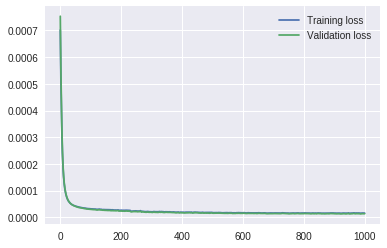

In [61]:
plt.plot(train_loss)
plt.plot(test_loss)
plt.legend(['Training loss', 'Validation loss'])

## Testing

### Calculate Signal-to-Noise Ratio using following formula

<img src="https://d1b10bmlvqabco.cloudfront.net/attach/jqcgj7tyoxz6oi/jl5gazm4ih22q1/jrx4uo8px5hd/SNR.JPG" width="400">


In [0]:
def snr(dirty, clean):
  return 10 * np.log10(np.sum(np.square(clean))/np.sum(np.square(clean - dirty)))

#### SNR for training data

In [63]:
cleaned = sess.run(output, feed_dict={X: X_train})
print(snr(cleaned, y_train))

18.027353286743164


#### SNR for validation data

In [64]:
cleaned = sess.run(output, feed_dict={X: X_test})
print(snr(cleaned, y_test))

12.996304035186768


## Prediction

In [0]:
def clean_audio(filename):
    # load audio file
    s, sr = librosa.load(filename, sr=None)
    
    # apply short time fourier transform
    dirty = librosa.stft(s, n_fft=1024, hop_length=512).T
    
    # take magnitudes of audio signals
    dirty_val = np.abs(dirty)
    
    total_samples = dirty_val.shape[0]
    batch_size = 100
    num_batches = int(math.ceil(total_samples/batch_size))
    
    # run it through the neural network to remove noisy bits
    clean_val = np.empty(shape=(0, 513), dtype='float')
    for itr in range(num_batches):
      start_idx = itr * batch_size
      end_idx = min((itr + 1) * batch_size, total_samples)
      
      batch_x = dirty_val[start_idx:end_idx].reshape(-1, 1, 513, 1)
      op = sess.run(output, feed_dict={X:batch_x, Y:batch_y})
      op = op.reshape(-1, 513)
        
      clean_val = np.concatenate([clean_val, op], axis=0)
    
    # recover speech spectogram of the cleaned signal
    cleaned = np.multiply(np.divide(dirty.T, dirty_val.T), clean_val.T)
    return cleaned

In [0]:
def save_audio(cleaned, to_filename):
    # recover time domain speech signal by applying inverse short time fourier transform
    sh_test = librosa.istft(cleaned, hop_length=512)
    
    # Save to a file
    librosa.output.write_wav(to_filename, sh_test, sr)
    print('Saved to ', to_filename)

In [67]:
cleaned = clean_audio(base_path + 'test_x_01.wav')
save_audio(cleaned, base_path + 'test_x_01_cleaned.wav')

Saved to  ./drive/My Drive/Colab Notebooks/Speech Denoising/Data/test_x_01_cleaned.wav


In [68]:
cleaned = clean_audio(base_path + 'test_x_02.wav')
save_audio(cleaned, base_path + 'test_x_02_cleaned.wav')

Saved to  ./drive/My Drive/Colab Notebooks/Speech Denoising/Data/test_x_02_cleaned.wav


In [69]:
cleaned = clean_audio(base_path + 'train_dirty_male.wav')
save_audio(cleaned, base_path + 'train_dirty_male_cleaned.wav')

Saved to  ./drive/My Drive/Colab Notebooks/Speech Denoising/Data/train_dirty_male_cleaned.wav


In [0]:
sess.close()